In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.optimize as opt
import json
import os
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
from sklearn.feature_selection import r_regression

from espncricinfo.match import Match

from tqdm import tqdm

C:\Users\adhva\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#!pip3 install python-espncricinfo

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# df_afg = scrape_afghanistan_t20is()
# df_afg.head()

In [5]:
# data = pd.read_csv('cricket_matches.csv')
# data

In [6]:
# teams = np.unique(np.append(data['team1'].values, data['team2'].values))
# teams

In [7]:
# data.columns.values

In [8]:
def prob_win_A(R_a: float, R_b: float, alpha: float = 400, home: str = 'neutral', hga: float = 0):
    if home == 'neutral':
        E_a = 1 / (1 + 10**( (R_b - R_a) / alpha ))
    elif home == 'first':
        E_a = 1 / (1 + 10**( (R_b - (R_a + hga) ) / alpha ))
    elif home == 'second':
        E_a = E_a = 1 / (1 + 10**( (R_b + hga - R_a) / alpha ))
    else:
        raise ValueError('Not a valid home country')
    return E_a

def elo_step(R_a: float, R_b: float, S: float, K: float, W_mv: float, alpha: float, home: str = 'neutral', hga: float = 0):
    E_a = prob_win_A(R_a, R_b, alpha, home, hga)
    E_b = 1 - E_a
    R_a_pr = R_a + K*(S - E_a)*W_mv
    R_b_pr = R_b + K*((1-S) - E_b)*W_mv
    
    return R_a_pr, R_b_pr

In [9]:
def prob_win_country_A(team_elos, country_A: str, country_B: str, venue_country: str, alpha: float = 400, hga: float = 0):
    """
    :param team_elos: Dictionary of elo ratings for each team.
    For the purposes of this function, country_A is the country for which win probability is calculated.
    """
    R_a = team_elos[country_A]
    R_b = team_elos[country_B]
    if venue_country == country_A:
        home = 'first'
    elif venue_country == country_B:
        home = 'second'
    else:
        home = 'neutral'
    return prob_win_A(R_a, R_b, alpha, home, hga)

In [10]:
def calculate_W_mv_m1(nrr):
    """
    :param nrr: Net run rate for game.
    """
    return (3 + nrr)**0.63 - 1 # Testing this out

def calculate_W_mv_log(nrr, elodiff):
    """
    :param nrr: Net run rate for game
    :param elodiff: Elo rating difference. ELODIFF = ELOW - ELOL
    """
    return np.log(1 + abs(min(nrr, 3))) * 2.2/(0.001*elodiff + 2.2) # Testing this out

In [11]:
def generate_elo_ratings(data, teams, K, alpha=400, calculate_W_mv=calculate_W_mv_log, hga=0, mean_rev_const=0.3):
    """
    :param data: DataFrame of games played.
    :param teams: Dictionary of all teams with respective elo rating scores. At the start, all teams' Elo ratings 
    will be set to 1500.
    :param K: K-parameter for Elo rating updates.
    :param alpha: alpha parameter for calculating probabilities from Elo.
    :param calculate_W_mv: Function for calculating the victory multiplier.
    
    Runs through Elo from start to finish for set of games, assuming that we are starting from the beginning -
    i.e. the teams do not have pre-existing Elo ratings calculated from other games and thus all initial
    Elo ratings are set to 1500.
    """
    teams_final = teams.copy()
    previous_year = 2025
    latest_changes = {t: 0 for t in teams_final.keys()}
    
    for i in range(data.shape[0]):
        row = data.iloc[i, :]
        
        first = row['first_team']
        second = row['second_team']
        winner = row['winner']
        nrr = row['net_run_rate']
        home_country = row['venue_country']
        year = row['year']
        
        if year > previous_year:
            previous_year = year
            avg = np.mean(np.array(list(teams_final.values())))
            for ind in np.array(list(teams_final.keys())):
                mean_rev = mean_rev_const*(teams_final[ind]-avg)
                teams_final[ind] -= mean_rev
        
        if home_country == first:
            home = 'first'
        elif home_country == second:
            home = 'second'
        else:
            home = 'neutral'
        
        if first == winner:
            S_a = 1
            loser = second
        elif winner == 'tie':
            S_a = 0.5
            loser = 'tie'
        else:
            S_a = 0
            loser = first
        
        if winner != 'tie':
            W_mv = calculate_W_mv(nrr, teams_final[winner]-teams_final[loser])
        else:
            W_mv = 2.2*np.log(2)
        R_a_pr, R_b_pr = elo_step(teams_final[first], teams_final[second], S_a, K, W_mv, alpha, home, hga)
        
        diff_a = R_a_pr - teams_final[first]
        diff_b = R_b_pr - teams_final[second]
        
        latest_changes[first] = diff_a
        latest_changes[second] = diff_b
        
        teams_final[first] = R_a_pr
        teams_final[second] = R_b_pr
    
    return teams_final, latest_changes

In [12]:
def brier(data, teams, K, alpha=400, calculate_W_mv=calculate_W_mv_log, hga=0, mean_rev_const=0.3):
    """
    :param data: DataFrame of all games.
    :param elodict: Dictionary of teams and their final Elo scores.
    :param alpha: alpha parameter.
    Assumes simulation has already been completed and Elo ratings calculated. Cross entropy loss for Elo ratings.
    """
    score = 0
    teams_final = teams.copy()
    previous_year = 2025
    
    for i in range(data.shape[0]):
        row = data.iloc[i, :]
        
        first = row['first_team']
        second = row['second_team']
        winner = row['winner']
        nrr = row['net_run_rate']
        
        home_country = row['venue_country']
        
        year = row['year']
        
        if year > previous_year:
            previous_year = year
            avg = np.mean(np.array(list(teams_final.values())))
            for ind in np.array(list(teams_final.keys())):
                mean_rev = mean_rev_const*(teams_final[ind]-avg)
                teams_final[ind] -= mean_rev
        
        if home_country == first:
            home = 'first'
        elif home_country == second:
            home = 'second'
        else:
            home = 'neutral'
        
        
        if first == winner:
            S_a = 1
            loser = second
        elif winner == 'tie':
            S_a = 0.5
            loser = 'tie'
        else:
            S_a = 0
            loser = first
        
        if winner != 'tie':
            W_mv = calculate_W_mv(nrr, teams_final[winner]-teams_final[loser])
        else:
            W_mv = 2.2*np.log(2)
            
        E_a = prob_win_A(teams_final[first], teams_final[second], alpha, home, hga)
        E_b = 1 - E_a
        
        R_a_pr, R_b_pr = elo_step(teams_final[first], teams_final[second], S_a, K, W_mv, alpha, home, hga)
        
        brier_comp = (S_a - E_a)**2 + ((1-S_a) - E_b)**2
        score += brier_comp
        
        teams_final[first] = R_a_pr
        teams_final[second] = R_b_pr
        
        # brier_comp = (S_a - E_a)**2 + ((1-S_a) - E_b)**2
    
    score /= data.shape[0]
    
    return score

In [13]:
# def cross_entropy(data, elodict, alpha=400):
#     """
#     :param data: DataFrame of all games.
#     :param elodict: Dictionary of teams and their final Elo scores.
#     :param alpha: alpha parameter.
#     Assumes simulation has already been completed and Elo ratings calculated. Cross entropy loss for Elo ratings.
#     """
#     score = 0
    
#     for i in range(data.shape[0]):
#         row = data.iloc[i, :]
        
        
#         first, second, winner = row['first_team'], row['second_team'], row['winner']
        
#         elo1, elo2 = elodict[first], elodict[second]
#         E_a = prob_win_A(elo1, elo2, alpha)
#         E_b = 1 - E_a
        
#         if first == winner:
#             S_a = 1
#         elif winner == 'tie':
#             S_a = 0.5
#         else:
#             S_a = 0
        
#         # brier_comp = (S_a - E_a)**2 + ((1-S_a) - E_b)**2
#         cross_entropy_comp = -(S_a*np.log(E_a) + (1-S_a)*np.log(1-E_a))
#         score += cross_entropy_comp
    
#     score /= data.shape[0]
    
#     return score

In [14]:
def cross_entropy(data, teams, K, alpha=400, calculate_W_mv=calculate_W_mv_log, hga=0, mean_rev_const=0.3):
    """
    :param data: DataFrame of all games.
    :param elodict: Dictionary of teams and their final Elo scores.
    :param alpha: alpha parameter.
    Assumes simulation has already been completed and Elo ratings calculated. Cross entropy loss for Elo ratings.
    """
    score = 0
    teams_final = teams.copy()
    previous_year = 2025
    
    for i in range(data.shape[0]):
        row = data.iloc[i, :]
        
        first = row['first_team']
        second = row['second_team']
        winner = row['winner']
        nrr = row['net_run_rate']
        
        home_country = row['venue_country']
        year = row['year']
        
        if year > previous_year:
            previous_year = year
            avg = np.mean(np.array(list(teams_final.values())))
            for ind in np.array(list(teams_final.keys())):
                mean_rev = mean_rev_const*(teams_final[ind]-avg)
                teams_final[ind] -= mean_rev
        
        if home_country == first:
            home = 'first'
        elif home_country == second:
            home = 'second'
        else:
            home = 'neutral'
        
        
        if first == winner:
            S_a = 1
            loser = second
        elif winner == 'tie':
            S_a = 0.5
            loser = 'tie'
        else:
            S_a = 0
            loser = first
        
        if winner != 'tie':
            W_mv = calculate_W_mv(nrr, teams_final[winner]-teams_final[loser])
        else:
            W_mv = 2.2*np.log(2)
            
        E_a = prob_win_A(teams_final[first], teams_final[second], alpha, home, hga)
        E_b = 1 - E_a
        
        R_a_pr, R_b_pr = elo_step(teams_final[first], teams_final[second], S_a, K, W_mv, alpha, home, hga)
        
        cross_entropy_comp = -(S_a*np.log(E_a) + (1-S_a)*np.log(1-E_a))
        score += cross_entropy_comp
        
        teams_final[first] = R_a_pr
        teams_final[second] = R_b_pr
        
        # brier_comp = (S_a - E_a)**2 + ((1-S_a) - E_b)**2
    
    score /= data.shape[0]
    
    return score

In [15]:
# def correctness(data, elodict, alpha=400): # TODO: Fix this
#     """
#     :param data: DataFrame of all games.
#     :param elodict: Dictionary of teams and their final Elo scores.
#     :param alpha: alpha parameter.
#     Assumes simulation has already been completed and Elo ratings calculated. Correctness (i.e., what %
#     of games are predicted correctly) for Elo ratings.
#     """
#     score = 0
    
#     for i in range(data.shape[0]):
#         row = data.iloc[i, :]
        
        
#         first, second, winner = row['first_team'], row['second_team'], row['winner']
        
#         elo1, elo2 = elodict[first], elodict[second]
#         E_a = prob_win_A(elo1, elo2, alpha)
#         E_b = 1 - E_a
        
#         if E_a >= 0.5:
#             S_exp = 1
#         else:
#             S_exp = 0
        
#         if first == winner:
#             S_a = 1
#         elif winner == 'tie':
#             S_a = 0.5
#         else:
#             S_a = 0
        
#         if S_exp == S_a:
#             score += 1
    
#     score /= data.shape[0]
    
#     return score

In [16]:
def correctness(data, teams, K, alpha=400, calculate_W_mv=calculate_W_mv_log, hga=0, mean_rev_const=0.3):
    """
    :param data: DataFrame of all games.
    :param elodict: Dictionary of teams and their final Elo scores.
    :param alpha: alpha parameter.
    Assumes simulation has already been completed and Elo ratings calculated. Cross entropy loss for Elo ratings.
    """
    score = 0
    teams_final = teams.copy()
    previous_year = 2025
    
    for i in range(data.shape[0]):
        row = data.iloc[i, :]
        
        first = row['first_team']
        second = row['second_team']
        winner = row['winner']
        nrr = row['net_run_rate']
        
        home_country = row['venue_country']
        year = row['year']
        
        if year > previous_year:
            previous_year = year
            avg = np.mean(np.array(list(teams_final.values())))
            for ind in np.array(list(teams_final.keys())):
                mean_rev = mean_rev_const*(teams_final[ind]-avg)
                teams_final[ind] -= mean_rev
        
        if home_country == first:
            home = 'first'
        elif home_country == second:
            home = 'second'
        else:
            home = 'neutral'
        
        
        if first == winner:
            S_a = 1
            loser = second
        elif winner == 'tie':
            S_a = 0.5
            loser = 'tie'
        else:
            S_a = 0
            loser = first
        
        if winner != 'tie':
            W_mv = calculate_W_mv(nrr, teams_final[winner]-teams_final[loser])
        else:
            W_mv = 2.2*np.log(2)
            
        E_a = prob_win_A(teams_final[first], teams_final[second], alpha, home, hga)
        E_b = 1 - E_a
        
        if E_a >= 0.5:
            S_exp = 1
        else:
            S_exp = 0
        
        R_a_pr, R_b_pr = elo_step(teams_final[first], teams_final[second], S_a, K, W_mv, alpha, home, hga)
        
        # cross_entropy_comp = -(S_a*np.log(E_a) + (1-S_a)*np.log(1-E_a))
        if S_exp == S_a:
            score += 1
        
        teams_final[first] = R_a_pr
        teams_final[second] = R_b_pr
        
        # brier_comp = (S_a - E_a)**2 + ((1-S_a) - E_b)**2
    
    score /= data.shape[0]
    
    return score

In [17]:
# data.iloc[0, :]

In [18]:
def extract_cricket_summary(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Get teams and winner
    teams = data['info']['teams']
    
    winner = data['info']['outcome'].get('winner')
    
    if winner is None:
        match data['info']['outcome'].get('result'):
            case 'no result':
                winner = 'no result'
            case 'tie':
                winner = 'tie'
                
    if data['info']['outcome'].get('method') == 'Awarded':
        print('Haiiiii! We at ', file_path, '<3')
    
    date = data['info']['dates'][0]
    
    teams_np = np.array(teams)
    
    loser = teams_np[teams_np != winner][0]
    
    first = (data['info']['toss']['winner'] if data['info']['toss']['decision']=='bat' 
             else teams_np[teams_np != data['info']['toss']['winner']][0])
    second = teams_np[teams_np != first][0]
    
    # city = data['info']['city']
    venue = data['info']['venue']

    team_stats = {}

    for innings in data['innings']:
        team = innings['team']
        total_runs = 0
        legal_balls = 0

        for over in innings['overs']:
            for delivery in over['deliveries']:
                # Add runs
                total_runs += delivery['runs']['total']
                
                # Count legal balls only (not wides or no-balls)
                extras = delivery.get('extras', {})
                if 'wides' not in extras and 'noballs' not in extras:
                    legal_balls += 1

        overs = legal_balls // 6 + (legal_balls % 6) / 10
        team_stats[team] = {
            'runs': total_runs,
            'balls': legal_balls,
            'overs': round(overs, 1)
        }
    
    if winner == 'no result' or data['info']['outcome'].get('method') == 'Awarded':
        nrr = float('nan')
    
    elif winner == 'tie':
        nrr = abs((team_stats[first]['runs'] - team_stats[second]['runs'])/20)
    
    elif team_stats[second]['balls'] <= 120 and winner == second: # quickfix: Condition on balls instead of overs
        nrr = team_stats[winner]['runs']/team_stats[winner]['overs'] - team_stats[loser]['runs']/team_stats[loser]['overs']
    
    else:
        nrr = (team_stats[winner]['runs'] - team_stats[loser]['runs']) / 20
    
    if winner == 'no result' or data['info']['outcome'].get('method') == 'Awarded': # For our purposes, matches with no result do not matter for Elo rating updates
        return {
        'date': date,
        'winner': winner,
        # 'city': city,
        'venue': venue,
        'first_team': first,
        'second_team': second,
        'first_runs': float('nan'),
        'first_balls': float('nan'),
        'first_overs': float('nan'),
        'second_runs': float('nan'),
        'second_balls': float('nan'),
        'second_overs': float('nan'),
        'net_run_rate': nrr
    }
    
    return {
        'date': date,
        'winner': winner,
        # 'city': city,
        'venue': venue,
        'first_team': first,
        'second_team': second,
        'first_runs': team_stats[first]['runs'],
        'first_balls': team_stats[first]['balls'],
        'first_overs': team_stats[first]['overs'],
        'second_runs': team_stats[second]['runs'],
        'second_balls': team_stats[second]['balls'],
        'second_overs': team_stats[second]['overs'],
        'net_run_rate': nrr
    }

In [19]:
# Example usage
summary = extract_cricket_summary("ipl-data/335984.json")
# summary = extract_cricket_summary("data/1407719.json")
print(summary)

{'date': '2008-04-19', 'winner': 'Delhi Daredevils', 'venue': 'Feroz Shah Kotla', 'first_team': 'Rajasthan Royals', 'second_team': 'Delhi Daredevils', 'first_runs': 129, 'first_balls': 120, 'first_overs': 20.0, 'second_runs': 132, 'second_balls': 91, 'second_overs': 15.1, 'net_run_rate': 2.291721854304636}


In [20]:
def load_directory(directory):
    summaries = []

    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            full_path = os.path.join(directory, filename)
            try:
                summary = extract_cricket_summary(full_path)
                if summary:
                    summaries.append(summary)
            except Exception as e:
                print(f"Error processing {filename}: {e}")

    return pd.DataFrame(summaries)

In [21]:
def calculate_nrr(winner, first, second, first_runs, first_overs, second_runs, second_overs):
    if winner == 'tie':
        nrr = abs((first_runs - second_runs)/20)
    elif second_overs <= 20 and winner == second:
        nrr = second_runs/second_overs - first_runs/first_overs
    elif winner == first:
        nrr = (first_runs - second_runs) / 20
    
    return nrr

In [22]:
# # afg = pd.read_csv('afghanistan-T20I-matches.csv')
# # print(afg['winner'])
# # afg['net_run_rate'] = afg[['winner', 'first_team', 'second_team', 'first_runs', 'first_overs', 'second_runs',
#                           'second_overs']].apply(lambda x: calculate_nrr(x['winner'], x['first_team'], x['second_team'],
#                                                                          x['first_runs'], x['first_overs'], x['second_runs'],
#                                                                          x['second_overs']), axis=1)
# # afg.head()

In [23]:
# app_matches = pd.read_csv('appended-mlc-matches-2025.csv')
# app_matches['net_run_rate'] = app_matches[['winner', 'first_team', 'second_team', 'first_runs', 'first_overs', 'second_runs',
#                           'second_overs']].apply(lambda x: calculate_nrr(x['winner'], x['first_team'], x['second_team'],
#                                                                          x['first_runs'], x['first_overs'], x['second_runs'],
#                                                                          x['second_overs']), axis=1)
# app_matches.head()

In [24]:
# data = load_directory('mlc-data/')
# data = pd.concat([data, app_matches], axis=0)
# # data = pd.concat([data, afg], axis=0)
# data = data.sort_values(by=['date'], ascending=True)
# data.head()

In [25]:
elo_df = pd.read_csv('mlc_init_elos-21-6-25.csv')
elo_df = elo_df.rename({'Unnamed: 0': 'team'}, axis=1)
elo_df

,team,elo
0,Los Angeles Knight Riders,1339.525936
1,MI New York,1486.364577
2,San Francisco Unicorns,1709.000210
3,Seattle Orcas,1326.218874
4,Texas Super Kings,1551.413864
5,Washington Freedom,1587.476539


In [26]:
team_elos = {team: elo for team, elo in zip(elo_df['team'], elo_df['elo'])}
team_elos

{'Los Angeles Knight Riders': 1339.5259362580473,
 'MI New York': 1486.3645770041378,
 'San Francisco Unicorns': 1709.000209843167,
 'Seattle Orcas': 1326.218874210684,
 'Texas Super Kings': 1551.413863706444,
 'Washington Freedom': 1587.476538977519}

In [27]:
grounds_to_home = {
    'Church Street Park, Morrisville': 'neutral',
    'Grand Prairie Stadium': 'Texas Super Kings',
    'Grand Prairie Stadium, Dallas': 'Texas Super Kings',
    'Oakland Coliseum,Oakland': 'San Francisco Unicorns',
    'Central Broward Regional Park Stadium, Lauderhill': 'neutral'
}

In [28]:
# K_opt, alpha_opt, hga_opt, mrc_opt = 106.48059306482318, 406.58672146000106, 0.0, 0.65
K_opt, alpha_opt, hga_opt, mrc_opt = (99.72452587983922,
 407.97950321556294,
 32.24964794902951,
 0.65)

In [29]:
upcoming = pd.read_csv('upcoming-mlc-matches-2025-dallas.csv')
upcoming['venue_country'] = upcoming['venue'].map(lambda x: grounds_to_home[x])
upcoming['date'] = pd.DatetimeIndex(upcoming['date'])
upcoming = upcoming.sort_values(by=['date'], ascending=True)
upcoming.head()

,date,first_team,second_team,venue,first_runs,first_balls,first_overs,second_runs,second_balls,second_overs,winner,venue_country
0,2025-06-21,MI New York,Washington Freedom,"Grand Prairie Stadium, Dallas",188.0,120.0,20.0,189.0,113.0,19.2,Washington Freedom,Texas Super Kings
1,2025-06-22,Los Angeles Knight Riders,Seattle Orcas,"Grand Prairie Stadium, Dallas",177.0,120.0,20.0,178.0,10.0,18.2,Los Angeles Knight Riders,Texas Super Kings
2,2025-06-22,Texas Super Kings,Washington Freedom,"Grand Prairie Stadium, Dallas",220.0,120.0,20.0,223.0,118.0,19.4,Washington Freedom,Texas Super Kings
3,2025-06-23,MI New York,San Francisco Unicorns,"Grand Prairie Stadium, Dallas",246.0,120.0,20.0,199.0,120.0,20.0,San Francisco Unicorns,Texas Super Kings
4,2025-06-24,Texas Super Kings,Los Angeles Knight Riders,"Grand Prairie Stadium, Dallas",196.0,120.0,20.0,144.0,120.0,20.0,Texas Super Kings,Texas Super Kings


In [30]:
upcoming['year'] = upcoming['date'].map(lambda x: x.year)
upcoming.head(1)

,date,first_team,second_team,venue,first_runs,first_balls,first_overs,second_runs,second_balls,second_overs,winner,venue_country,year
0,2025-06-21,MI New York,Washington Freedom,"Grand Prairie Stadium, Dallas",188.0,120.0,20.0,189.0,113.0,19.2,Washington Freedom,Texas Super Kings,2025


In [31]:
done = upcoming[~upcoming['winner'].isna()]
upcoming = upcoming[upcoming['winner'].isna()]
done

,date,first_team,second_team,venue,first_runs,first_balls,first_overs,second_runs,second_balls,second_overs,winner,venue_country,year
0,2025-06-21,MI New York,Washington Freedom,"Grand Prairie Stadium, Dallas",188.0,120.0,20.0,189.0,113.0,19.2,Washington Freedom,Texas Super Kings,2025
1,2025-06-22,Los Angeles Knight Riders,Seattle Orcas,"Grand Prairie Stadium, Dallas",177.0,120.0,20.0,178.0,10.0,18.2,Los Angeles Knight Riders,Texas Super Kings,2025
2,2025-06-22,Texas Super Kings,Washington Freedom,"Grand Prairie Stadium, Dallas",220.0,120.0,20.0,223.0,118.0,19.4,Washington Freedom,Texas Super Kings,2025
3,2025-06-23,MI New York,San Francisco Unicorns,"Grand Prairie Stadium, Dallas",246.0,120.0,20.0,199.0,120.0,20.0,San Francisco Unicorns,Texas Super Kings,2025
4,2025-06-24,Texas Super Kings,Los Angeles Knight Riders,"Grand Prairie Stadium, Dallas",196.0,120.0,20.0,144.0,120.0,20.0,Texas Super Kings,Texas Super Kings,2025
5,2025-06-25,San Francisco Unicorns,Seattle Orcas,"Grand Prairie Stadium, Dallas",176.0,120.0,20.0,144.0,110.0,18.2,San Francisco Unicorns,Texas Super Kings,2025
6,2025-06-26,Los Angeles Knight Riders,Washington Freedom,"Grand Prairie Stadium, Dallas",213.0,120.0,20.0,214.0,120.0,20.0,Washington Freedom,Texas Super Kings,2025
7,2025-06-27,MI New York,Seattle Orcas,"Grand Prairie Stadium, Dallas",237.0,120.0,20.0,238.0,120.0,20.0,Seattle Orcas,Texas Super Kings,2025
8,2025-06-28,San Francisco Unicorns,Washington Freedom,"Grand Prairie Stadium, Dallas",169.0,120.0,20.0,157.0,120.0,20.0,Washington Freedom,Texas Super Kings,2025
10,2025-06-28,Los Angeles Knight Riders,Seattle Orcas,"Grand Prairie Stadium, Dallas",202.0,120.0,20.0,206.0,119.0,20.0,Seattle Orcas,Texas Super Kings,2025


In [32]:
upcoming = upcoming.drop(['first_runs', 'first_balls', 'first_overs', 'second_runs', 'second_balls', 'second_overs',
                         'winner'], axis=1)
upcoming.shape

(6, 6)

In [33]:
done['net_run_rate'] = done[['winner', 'first_team', 'second_team', 'first_runs', 'first_overs', 'second_runs',
                          'second_overs']].apply(lambda x: calculate_nrr(x['winner'], x['first_team'], x['second_team'],
                                                                         x['first_runs'], x['first_overs'], x['second_runs'],
                                                                         x['second_overs']), axis=1)
done.head()

,date,first_team,second_team,venue,first_runs,first_balls,first_overs,second_runs,second_balls,second_overs,winner,venue_country,year,net_run_rate
0,2025-06-21,MI New York,Washington Freedom,"Grand Prairie Stadium, Dallas",188.0,120.0,20.0,189.0,113.0,19.2,Washington Freedom,Texas Super Kings,2025,0.443750
1,2025-06-22,Los Angeles Knight Riders,Seattle Orcas,"Grand Prairie Stadium, Dallas",177.0,120.0,20.0,178.0,10.0,18.2,Los Angeles Knight Riders,Texas Super Kings,2025,-0.050000
2,2025-06-22,Texas Super Kings,Washington Freedom,"Grand Prairie Stadium, Dallas",220.0,120.0,20.0,223.0,118.0,19.4,Washington Freedom,Texas Super Kings,2025,0.494845
3,2025-06-23,MI New York,San Francisco Unicorns,"Grand Prairie Stadium, Dallas",246.0,120.0,20.0,199.0,120.0,20.0,San Francisco Unicorns,Texas Super Kings,2025,-2.350000
4,2025-06-24,Texas Super Kings,Los Angeles Knight Riders,"Grand Prairie Stadium, Dallas",196.0,120.0,20.0,144.0,120.0,20.0,Texas Super Kings,Texas Super Kings,2025,2.600000


In [34]:
team_elos, latest_changes = generate_elo_ratings(done, team_elos, K=K_opt, alpha=alpha_opt, hga=hga_opt, mean_rev_const=mrc_opt)
team_elos = dict(sorted(team_elos.items(), key=lambda item: item[1], reverse=True))
team_elos

{'San Francisco Unicorns': 1673.484982413114,
 'Texas Super Kings': 1659.3811245080165,
 'Washington Freedom': 1583.2536634353944,
 'MI New York': 1441.3434767033934,
 'Seattle Orcas': 1361.8520165508633,
 'Los Angeles Knight Riders': 1280.6847363892177}

In [35]:
upcoming['first_team_win_chance'] = upcoming.apply(lambda x: prob_win_country_A(team_elos, x['first_team'], x['second_team'],
                                                                               x['venue_country'], alpha=alpha_opt, hga=hga_opt), axis=1)
upcoming['second_team_win_chance'] = upcoming['first_team_win_chance'].map(lambda x: 1 - x)
upcoming

,date,first_team,second_team,venue,venue_country,year,first_team_win_chance,second_team_win_chance
14,2025-07-04,San Francisco Unicorns,Texas Super Kings,"Central Broward Regional Park Stadium, Lauderhill",neutral,2025,0.519890,0.480110
15,2025-07-04,Seattle Orcas,Washington Freedom,"Central Broward Regional Park Stadium, Lauderhill",neutral,2025,0.222776,0.777224
16,2025-07-05,Los Angeles Knight Riders,MI New York,"Central Broward Regional Park Stadium, Lauderhill",neutral,2025,0.287668,0.712332
17,2025-07-05,Seattle Orcas,Texas Super Kings,"Central Broward Regional Park Stadium, Lauderhill",neutral,2025,0.157199,0.842801
18,2025-07-06,MI New York,Washington Freedom,"Central Broward Regional Park Stadium, Lauderhill",neutral,2025,0.309828,0.690172
19,2025-07-06,Los Angeles Knight Riders,San Francisco Unicorns,"Central Broward Regional Park Stadium, Lauderhill",neutral,2025,0.098242,0.901758


In [36]:
abbrs = {
    'San Francisco Unicorns': 'SFU',
    'Los Angeles Knight Riders': 'LAKR',
    'MI New York': 'MINY',
    'Seattle Orcas': 'SEO',
    'Texas Super Kings': 'TSK',
    'Washington Freedom': 'WF'
}

In [37]:
curr_elos = pd.DataFrame([team_elos, abbrs], index=[0, 1]).T
curr_elos = curr_elos.rename({0: 'Current Elo', 1:'Abbr.'}, axis=1)
curr_elos = curr_elos[['Abbr.', 'Current Elo']]
curr_elos.to_csv('curr_elos.csv')
curr_elos['Current Elo'] = curr_elos['Current Elo'].map(lambda x: int(np.round(x, 0)))
curr_elos

,Abbr.,Current Elo
San Francisco Unicorns,SFU,1673
Texas Super Kings,TSK,1659
Washington Freedom,WF,1583
MI New York,MINY,1441
Seattle Orcas,SEO,1362
Los Angeles Knight Riders,LAKR,1281


In [38]:
curr_elos.to_csv('curr_elos_display.csv')

In [39]:
# str(int(np.round(max(0.3, 0.7) * 100, 0)))

In [40]:
upcoming_disp = upcoming.copy()
upcoming_disp['Match'] = upcoming_disp.apply(lambda x: abbrs[x['first_team']] + ' v. ' + abbrs[x['second_team']], axis=1)
upcoming_disp['Odds'] = upcoming_disp.apply(lambda x: str(int(np.round(max(x['first_team_win_chance'], x['second_team_win_chance']) * 100, 0))) +
                                                         '% ' + str((abbrs[x['first_team']] if x['first_team_win_chance'] > x['second_team_win_chance']
                                                                else abbrs[x['second_team']])), axis=1)
upcoming_disp['Predicted Winner'] = upcoming_disp.apply(lambda x: (abbrs[x['first_team']] if x['first_team_win_chance'] > x['second_team_win_chance']
                                                                else abbrs[x['second_team']]), axis=1)
upcoming_disp

,date,first_team,second_team,venue,venue_country,year,first_team_win_chance,second_team_win_chance,Match,Odds,Predicted Winner
14,2025-07-04,San Francisco Unicorns,Texas Super Kings,"Central Broward Regional Park Stadium, Lauderhill",neutral,2025,0.519890,0.480110,SFU v. TSK,52% SFU,SFU
15,2025-07-04,Seattle Orcas,Washington Freedom,"Central Broward Regional Park Stadium, Lauderhill",neutral,2025,0.222776,0.777224,SEO v. WF,78% WF,WF
16,2025-07-05,Los Angeles Knight Riders,MI New York,"Central Broward Regional Park Stadium, Lauderhill",neutral,2025,0.287668,0.712332,LAKR v. MINY,71% MINY,MINY
17,2025-07-05,Seattle Orcas,Texas Super Kings,"Central Broward Regional Park Stadium, Lauderhill",neutral,2025,0.157199,0.842801,SEO v. TSK,84% TSK,TSK
18,2025-07-06,MI New York,Washington Freedom,"Central Broward Regional Park Stadium, Lauderhill",neutral,2025,0.309828,0.690172,MINY v. WF,69% WF,WF
19,2025-07-06,Los Angeles Knight Riders,San Francisco Unicorns,"Central Broward Regional Park Stadium, Lauderhill",neutral,2025,0.098242,0.901758,LAKR v. SFU,90% SFU,SFU


In [41]:
upcoming_disp = upcoming_disp.rename({'date': 'Date'}, axis=1)
upcoming_disp['venue'] = upcoming_disp['venue'].map(lambda x: '^Venue: ' + x + '^')
upcoming_disp['Match'] = upcoming_disp['Match'] + upcoming_disp['venue']
upcoming_disp = upcoming_disp[['Date', 'Match', 'Odds', 'Predicted Winner']]
upcoming_disp

,Date,Match,Odds,Predicted Winner
14,2025-07-04,SFU v. TSK^Venue: Central Broward Regional Par...,52% SFU,SFU
15,2025-07-04,SEO v. WF^Venue: Central Broward Regional Park...,78% WF,WF
16,2025-07-05,LAKR v. MINY^Venue: Central Broward Regional P...,71% MINY,MINY
17,2025-07-05,SEO v. TSK^Venue: Central Broward Regional Par...,84% TSK,TSK
18,2025-07-06,MINY v. WF^Venue: Central Broward Regional Par...,69% WF,WF
19,2025-07-06,LAKR v. SFU^Venue: Central Broward Regional Pa...,90% SFU,SFU


In [42]:
upcoming_disp.to_csv('upcoming_display.csv')

In [43]:
past = pd.read_csv('past_matches_mlc_2025.csv')
# all_past = past.copy()
past.head(3)

,Unnamed: 0,date,winner,venue,first_team,second_team,first_runs,first_balls,first_overs,second_runs,second_balls,second_overs,net_run_rate,year,venue_country
0,0,2023-07-13,Texas Super Kings,Grand Prairie Stadium,Texas Super Kings,Los Angeles Knight Riders,181.0,120.0,20.0,112.0,84.0,14.0,3.450000,2023,Texas Super Kings
1,1,2023-07-14,San Francisco Unicorns,Grand Prairie Stadium,San Francisco Unicorns,MI New York,215.0,120.0,20.0,193.0,120.0,20.0,1.100000,2023,Texas Super Kings
2,2,2023-07-14,Seattle Orcas,Grand Prairie Stadium,Washington Freedom,Seattle Orcas,144.0,120.0,20.0,148.0,118.0,19.4,0.428866,2023,Texas Super Kings


In [44]:
past = pd.concat([past, done], axis=0)
all_past = past.copy()
past = past[past['year'] == 2025]
past.shape

(24, 15)

In [45]:
teams_lst = np.array(list(abbrs.keys()))
teams_lst

array(['San Francisco Unicorns', 'Los Angeles Knight Riders',
       'MI New York', 'Seattle Orcas', 'Texas Super Kings',
       'Washington Freedom'], dtype='<U25')

In [46]:
points = {t: 0 for t in teams_lst}
points

{'San Francisco Unicorns': 0,
 'Los Angeles Knight Riders': 0,
 'MI New York': 0,
 'Seattle Orcas': 0,
 'Texas Super Kings': 0,
 'Washington Freedom': 0}

In [47]:
def calculate_points(data, teams):
    """
    :param data: DataFrame of games played.
    :param teams: Dictionary of all teams with respective points. At the start, all teams' Elo ratings 
    will be set to 0.
    
    Calculates points gathered for each team, given a DataFrame `data` of matches played.
    """
    teams_final = teams.copy()
    # previous_year = 2025
    
    for i in range(data.shape[0]):
        row = data.iloc[i, :]
        
        first = row['first_team']
        second = row['second_team']
        winner = row['winner']
        nrr = row['net_run_rate']
        home_country = row['venue_country']
        year = row['year']
        
        if winner == 'no result':
            teams_final[first] += 1
            teams_final[second] += 1
        
        else:
            teams_final[winner] += 2
    
    return teams_final

In [48]:
points = calculate_points(past, points)
points

{'San Francisco Unicorns': 12,
 'Los Angeles Knight Riders': 2,
 'MI New York': 4,
 'Seattle Orcas': 6,
 'Texas Super Kings': 12,
 'Washington Freedom': 12}

In [49]:
team_elos

{'San Francisco Unicorns': 1673.484982413114,
 'Texas Super Kings': 1659.3811245080165,
 'Washington Freedom': 1583.2536634353944,
 'MI New York': 1441.3434767033934,
 'Seattle Orcas': 1361.8520165508633,
 'Los Angeles Knight Riders': 1280.6847363892177}

In [50]:
# l = [0, 3, 2, 3, 2, 5]
# l[:4]

In [51]:
# curr_elos

In [52]:
def elodiffs_vs_nrrs(data, teams, K, alpha=400, calculate_W_mv=calculate_W_mv_log, hga=0, mean_rev_const=0.3):
    """
    :param data: DataFrame of games played.
    :param teams: Dictionary of all teams with respective elo rating scores. At the start, all teams' Elo ratings 
    will be set to 1500.
    :param K: K-parameter for Elo rating updates.
    :param alpha: alpha parameter for calculating probabilities from Elo.
    :param calculate_W_mv: Function for calculating the victory multiplier.
    
    Returns lists of Elo rating differences and net run rates for each match.
    """
    teams_final = teams.copy()
    previous_year = 2008
    
    elodiffs = []
    nrrs = []
    it = 0
    
    for i in range(data.shape[0]):
        row = data.iloc[i, :]
        
        first = row['first_team']
        second = row['second_team']
        winner = row['winner']
        nrr = row['net_run_rate']
        home_country = row['venue_country']
        year = row['year']
        
        if year > previous_year:
            previous_year = year
            avg = np.mean(np.array(list(teams_final.values())))
            for ind in np.array(list(teams_final.keys())):
                mean_rev = mean_rev_const*(teams_final[ind]-avg)
                teams_final[ind] -= mean_rev
        
        if home_country == first:
            home = 'first'
        elif home_country == second:
            home = 'second'
        else:
            home = 'neutral'
        
        if first == winner:
            S_a = 1
            loser = second
        elif winner == 'tie':
            S_a = 0.5
            loser = 'tie'
        else:
            S_a = 0
            loser = first
        
        E_a = prob_win_A(teams_final[first], teams_final[second], alpha, home, hga)
        if E_a >= 0.5:
            S_exp = 1
        else:
            S_exp = 0
        
        if winner != 'tie':
            W_mv = calculate_W_mv(nrr, teams_final[winner]-teams_final[loser])
        else:
            W_mv = 2.2*np.log(2)
        R_a_pr, R_b_pr = elo_step(teams_final[first], teams_final[second], S_a, K, W_mv, alpha, home, hga)
        
        if it > 0:
            elodiff = teams_final[first] - teams_final[second]
            nrr = nrr if winner == first else -nrr
            
            if S_a == S_exp:
                elodiffs.append(elodiff)
                nrrs.append(nrr)
        
        teams_final[first] = R_a_pr
        teams_final[second] = R_b_pr
        
        if it == 0:
            it += 1
    
    return np.array([elodiffs]).T, np.array(nrrs).T

In [53]:
elodiffs, nrrs = elodiffs_vs_nrrs(all_past, team_elos, K=K_opt, alpha=alpha_opt, hga=hga_opt, mean_rev_const=mrc_opt)
elodiffs, nrrs

(array([[  81.249527  ],
        [  65.48231099],
        [  67.98496894],
        [ 187.07399428],
        [-210.2571324 ],
        [   4.18652121],
        [ -48.62197907],
        [  48.06755526],
        [ -78.6107876 ],
        [ -34.5458729 ],
        [ -14.99228925],
        [ -56.60204631],
        [ -27.35302496],
        [-124.27019046],
        [   3.20533063],
        [   9.80842772],
        [  42.79431793],
        [-103.9992478 ],
        [ -84.3044929 ],
        [ 171.04031603],
        [ -39.63587916],
        [  75.3114897 ],
        [  24.58703951],
        [ 134.79440407],
        [ -57.34666985],
        [  95.16322728],
        [-127.38864232],
        [ 188.0954664 ],
        [ 172.59945569],
        [-120.75150083],
        [-101.02373011],
        [  12.02208591],
        [ -62.5437576 ],
        [-218.86184311],
        [ 172.79956842],
        [ 387.11451132],
        [-299.32806682],
        [  -7.57232625],
        [ 102.44289642],
        [-103.69971843]])

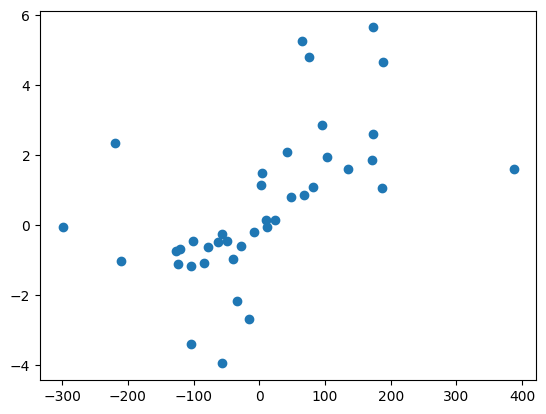

In [54]:
plt.scatter(elodiffs, nrrs)

In [55]:
reg = lm.LinearRegression()
reg.fit(elodiffs, nrrs)
reg.coef_, reg.intercept_

(array([0.00936326]), 0.5178300622759535)

In [56]:
1/reg.coef_

array([106.80044044])

In [57]:
r_regression(elodiffs, nrrs)

array([0.56202677])

In [58]:
coef, inter = reg.coef_, reg.intercept_
coef, inter

(array([0.00936326]), 0.5178300622759535)

In [59]:
expected_nrrs = reg.coef_[0]*elodiffs + reg.intercept_
mse = np.sum((expected_nrrs-nrrs)**2) / nrrs.shape[0]
mse

241.86869530404337

In [60]:
def elodiffs_vs_nrrs_upsets(data, teams, K, alpha=400, calculate_W_mv=calculate_W_mv_log, hga=0, mean_rev_const=0.3):
    """
    :param data: DataFrame of games played.
    :param teams: Dictionary of all teams with respective elo rating scores. At the start, all teams' Elo ratings 
    will be set to 1500.
    :param K: K-parameter for Elo rating updates.
    :param alpha: alpha parameter for calculating probabilities from Elo.
    :param calculate_W_mv: Function for calculating the victory multiplier.
    
    Returns lists of Elo rating differences and net run rates for each match that resulted in an upset.
    """
    
    ### Only tracks upsets
    teams_final = teams.copy()
    previous_year = 2008
    
    elodiffs = []
    nrrs = []
    it = 0
    
    for i in range(data.shape[0]):
        row = data.iloc[i, :]
        
        first = row['first_team']
        second = row['second_team']
        winner = row['winner']
        nrr = row['net_run_rate']
        home_country = row['venue_country']
        year = row['year']
        
        if year > previous_year:
            previous_year = year
            avg = np.mean(np.array(list(teams_final.values())))
            for ind in np.array(list(teams_final.keys())):
                mean_rev = mean_rev_const*(teams_final[ind]-avg)
                teams_final[ind] -= mean_rev
        
        if home_country == first:
            home = 'first'
        elif home_country == second:
            home = 'second'
        else:
            home = 'neutral'
        
        if first == winner:
            S_a = 1
            loser = second
        elif winner == 'tie':
            S_a = 0.5
            loser = 'tie'
        else:
            S_a = 0
            loser = first
        
        if winner != 'tie':
            W_mv = calculate_W_mv(nrr, teams_final[winner]-teams_final[loser])
        else:
            W_mv = 2.2*np.log(2)
        R_a_pr, R_b_pr = elo_step(teams_final[first], teams_final[second], S_a, K, W_mv, alpha, home, hga)
        
        E_a = prob_win_A(teams_final[first], teams_final[second], alpha, home, hga)
        
        if E_a >= 0.5:
            S_exp = 1
        else:
            S_exp = 0
        
        if it > 0:
            elodiff = teams_final[first] - teams_final[second]
            nrr = nrr if winner == first else -nrr
            
            if S_exp != S_a:
                elodiffs.append(elodiff)
                nrrs.append(nrr)
        
        teams_final[first] = R_a_pr
        teams_final[second] = R_b_pr
        
        if it == 0:
            it += 1
    
    return np.array([elodiffs]).T, np.array(nrrs).T

In [61]:
elodiffs, nrrs = elodiffs_vs_nrrs_upsets(all_past, team_elos, K=K_opt, alpha=alpha_opt, hga=hga_opt, mean_rev_const=mrc_opt)
elodiffs, nrrs

(array([[  77.49057641],
        [-114.29408688],
        [ -85.94857225],
        [  52.37833079],
        [  99.70398242],
        [ 301.54119238],
        [  17.67338244],
        [ -16.14405307],
        [  36.46238062],
        [ -44.05514066],
        [ 116.00486008],
        [  90.5910316 ],
        [ -39.16072022],
        [  -9.79010239],
        [  40.6306933 ],
        [ 122.87764161],
        [  23.96259496],
        [ -10.31691634],
        [ -63.3481695 ],
        [ -24.83559537],
        [ 127.04340522],
        [ 106.94164265],
        [ 359.31734416],
        [ -69.55028718]]),
 array([-0.42886598,  1.75      ,  0.3       , -1.65      , -2.52287582,
        -0.66230366, -0.45625   , -2.16666667, -2.35      ,  0.6       ,
         0.26756757, -2.98285714,  0.75      ,  4.7       , -0.38691099,
        -1.8364062 , -2.10698314,  0.5       ,  6.15      , -2.64658385,
        -0.05      ,  0.6       , -0.35647668,  2.15      ]))

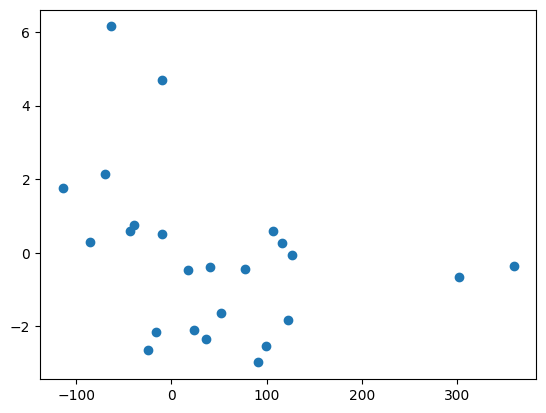

In [62]:
plt.scatter(elodiffs, nrrs)

In [63]:
reg = lm.LinearRegression()
reg.fit(elodiffs, nrrs)
reg.coef_, reg.intercept_

(array([-0.00656019]), 0.18120619237911317)

In [64]:
r_regression(elodiffs, nrrs)

array([-0.332675])

In [65]:
coef_u, inter_u = reg.coef_, reg.intercept_
coef_u, inter_u

(array([-0.00656019]), 0.18120619237911317)

In [66]:
expected_nrrs = reg.coef_[0]*elodiffs + reg.intercept_
mse = np.sum((expected_nrrs-nrrs)**2) / nrrs.shape[0]
mse

125.59989631676098

In [67]:
team_elos

{'San Francisco Unicorns': 1673.484982413114,
 'Texas Super Kings': 1659.3811245080165,
 'Washington Freedom': 1583.2536634353944,
 'MI New York': 1441.3434767033934,
 'Seattle Orcas': 1361.8520165508633,
 'Los Angeles Knight Riders': 1280.6847363892177}

In [68]:
points

{'San Francisco Unicorns': 12,
 'Los Angeles Knight Riders': 2,
 'MI New York': 4,
 'Seattle Orcas': 6,
 'Texas Super Kings': 12,
 'Washington Freedom': 12}

In [69]:
# pd.DataFrame({'a': [1, 2, 3], 'b': [2, 3, 4]})

In [70]:
def simulate(upcoming, teams, K, alpha=400, calculate_W_mv=calculate_W_mv_log, hga=0, mean_rev_const=0.3, N=1, points={}):
    """
    :param upcoming: DataFrame of upcoming matches.
    :param teams: Dictionary of all teams with respective elo rating scores. This presumes that the Elo ratings have been updated
    for most recent matches.
    :param K: K-parameter for Elo rating updates.
    :param alpha: alpha parameter for calculating probabilities from Elo.
    :param calculate_W_mv: Function for calculating the victory multiplier.
    :param N: Number of times that simulation is run.
    
    Simulate remaining matches and playoffs.
    """
    
    playoffs = {t: [] for t in teams_lst}
    finals = {t: [] for t in teams_lst}
    champion = {t: [] for t in teams_lst}
    
    
    previous_year = 2025
    
    for n in tqdm(range(N)):
        teams_final = teams.copy()
        teams_points = points.copy()
        remaining = upcoming.copy()
#         for i in range(data.shape[0]):
            
#             row = data.iloc[i, :]

#             first = row['first_team']
#             second = row['second_team']
#             winner = row['winner']
#             nrr = row['net_run_rate']
#             home_country = row['venue_country']
#             year = row['year']

#             if year > previous_year:
#                 previous_year = year
#                 avg = np.mean(np.array(list(teams_final.values())))
#                 for ind in np.array(list(teams_final.keys())):
#                     mean_rev = mean_rev_const*(teams_final[ind]-avg)
#                     teams_final[ind] -= mean_rev

#             if home_country == first:
#                 home = 'first'
#             elif home_country == second:
#                 home = 'second'
#             else:
#                 home = 'neutral'

#             if first == winner:
#                 S_a = 1
#                 loser = second
#             elif winner == 'tie':
#                 S_a = 0.5
#                 loser = 'tie'
#             else:
#                 S_a = 0
#                 loser = first

#             if winner != 'tie':
#                 W_mv = calculate_W_mv(nrr, teams_final[winner]-teams_final[loser])
#             else:
#                 W_mv = 2.2*np.log(2)
#             R_a_pr, R_b_pr = elo_step(teams_final[first], teams_final[second], S_a, K, W_mv, alpha, home, hga)

#             teams_final[first] = R_a_pr
#             teams_final[second] = R_b_pr

#             if winner == 'no result':
#                 teams_points[first] += 1
#                 teams_points[second] += 1
#             else:
#                 teams_points[winner] += 2
        
        remaining['first_team_win_chance'] = remaining.apply(lambda x: prob_win_country_A(teams_final, x['first_team'], x['second_team'],
                                                                               x['venue_country'], alpha=alpha_opt, hga=hga_opt), axis=1)
        remaining['second_team_win_chance'] = remaining['first_team_win_chance'].map(lambda x: 1 - x)
        for i in range(remaining.shape[0]):
            
            row = remaining.iloc[i, :]
            
            first = row['first_team']
            second = row['second_team']
            home_country = row['venue_country']
            year = row['year']
            first_chance = row['first_team_win_chance']
            second_chance = row['second_team_win_chance']
            
            S = np.random.choice(2, 1, p=[first_chance, second_chance])
            
            if home_country == first:
                home = 'first'
            elif home_country == second:
                home = 'second'
            else:
                home = 'neutral'
            
            if S == 0:
                winner = first
                loser = second
            else:
                winner = second
                loser = first
            
            elodiff = teams_final[winner] - teams_final[loser]
            
            if elodiff < 0:
                exp_nrr = abs(coef_u * elodiff + inter_u)
            else:
                exp_nrr = abs(coef * elodiff + inter)
            
            W_mv = calculate_W_mv(exp_nrr, teams_final[winner]-teams_final[loser])
            R_a_pr, R_b_pr = elo_step(teams_final[first], teams_final[second], S, K, W_mv, alpha, home, hga)

            teams_final[first] = R_a_pr
            teams_final[second] = R_b_pr

            if winner == 'no result':
                teams_points[first] += 1
                teams_points[second] += 1
            else:
                teams_points[winner] += 2
            
            
        
        top_4 = list(dict(sorted(teams_points.items(), key=lambda item: item[1], reverse=True)).keys())[:4]
        
        for t in playoffs.keys():
            if t in top_4:
                playoffs[t].append(1)
            else:
                playoffs[t].append(0)
        
        qual_1, qual_2 = top_4[0], top_4[1]
        elim_3, elim_4 = top_4[2], top_4[3] # vars named like this to keep track of place, i.e. 3rd and 4th in rankings
        
        playoffs_df = pd.DataFrame()
        
        qual_match = {'date': pd.to_datetime('2025-07-08'), 'first_team': qual_1, 'second_team': qual_2,
                     'venue': 'Grand Prairie Stadium, Dallas', 'venue_country': 'Texas Super Kings', 'year': 2025}
        elim_match = {'date': pd.to_datetime('2025-07-09'), 'first_team': elim_3, 'second_team': elim_4,
                     'venue': 'Grand Prairie Stadium, Dallas', 'venue_country': 'Texas Super Kings', 'year': 2025}
        
        playoffs_df = pd.concat([playoffs_df, pd.DataFrame(qual_match, index=[0]), pd.DataFrame(elim_match, index=[1])], axis=0)
        
        playoffs_df['first_team_win_chance'] = playoffs_df.apply(lambda x: prob_win_country_A(teams_final, x['first_team'], x['second_team'],
                                                                               x['venue_country'], alpha=alpha_opt, hga=hga_opt), axis=1)
        playoffs_df['second_team_win_chance'] = playoffs_df['first_team_win_chance'].map(lambda x: 1 - x)
        
        qual_winner = 'none'
        qual_loser = 'none'
        elim_winner = 'none'
        elim_loser  = 'none'
        
        for i in range(playoffs_df.shape[0]):
            row = playoffs_df.iloc[i, :]
            
            first = row['first_team']
            second = row['second_team']
            home_country = row['venue_country']
            year = row['year']
            first_chance = row['first_team_win_chance'][0]
            second_chance = row['second_team_win_chance'][0]
            
            if first == qual_1:
                is_qual = True
            else:
                is_qual = False
            
            # print(first_chance, second_chance)
            S = np.random.choice(2, 1, p=[first_chance, second_chance])
            
            if home_country == first:
                home = 'first'
            elif home_country == second:
                home = 'second'
            else:
                home = 'neutral'

            
            if S == 0:
                winner = first
                loser = second
            else:
                winner = second
                loser = first
            
            elodiff = teams_final[winner] - teams_final[loser]
            
            if elodiff < 0:
                exp_nrr = abs(coef_u * elodiff + inter_u)
            else:
                exp_nrr = abs(coef * elodiff + inter)
            
            W_mv = calculate_W_mv(exp_nrr, teams_final[winner]-teams_final[loser])
            R_a_pr, R_b_pr = elo_step(teams_final[first], teams_final[second], S, K, W_mv, alpha, home, hga)

            teams_final[first] = R_a_pr
            teams_final[second] = R_b_pr
            
            if is_qual:
                qual_winner = winner
                qual_loser = loser
            else:
                elim_winner = winner
                elim_loser = loser

            if winner == 'no result':
                teams_points[first] += 1
                teams_points[second] += 1
            else:
                teams_points[winner] += 2
        
        chall_match = {'date': pd.to_datetime('2025-07-11'), 'first_team': qual_loser, 'second_team': elim_winner,
                     'venue': 'Grand Prairie Stadium, Dallas', 'venue_country': 'Texas Super Kings', 'year': 2025}
        
        playoffs_df = pd.DataFrame(chall_match, index=[0])
        
        playoffs_df['first_team_win_chance'] = playoffs_df.apply(lambda x: prob_win_country_A(teams_final, x['first_team'], x['second_team'],
                                                                               x['venue_country'], alpha=alpha_opt, hga=hga_opt), axis=1)
        playoffs_df['second_team_win_chance'] = playoffs_df['first_team_win_chance'].map(lambda x: 1 - x)
        
        chall_winner = 'none'
        chall_loser = 'none'
        
        for i in range(playoffs_df.shape[0]):
            row = playoffs_df.iloc[i, :]
            
            first = row['first_team']
            second = row['second_team']
            home_country = row['venue_country']
            year = row['year']
            first_chance = row['first_team_win_chance'][0]
            second_chance = row['second_team_win_chance'][0]
            
            S = np.random.choice(2, 1, p=[first_chance, second_chance])
            
            if home_country == first:
                home = 'first'
            elif home_country == second:
                home = 'second'
            else:
                home = 'neutral'
            
            if S == 0:
                winner = first
                loser = second
            else:
                winner = second
                loser = first
            
            elodiff = teams_final[winner] - teams_final[loser]
            
            if elodiff < 0:
                exp_nrr = abs(coef_u * elodiff + inter_u)
            else:
                exp_nrr = abs(coef * elodiff + inter)
            
            W_mv = calculate_W_mv(exp_nrr, teams_final[winner]-teams_final[loser])
            R_a_pr, R_b_pr = elo_step(teams_final[first], teams_final[second], S, K, W_mv, alpha, home, hga)

            teams_final[first] = R_a_pr
            teams_final[second] = R_b_pr
            
            chall_winner = winner
            chall_loser = loser

            if winner == 'no result':
                teams_points[first] += 1
                teams_points[second] += 1
            else:
                teams_points[winner] += 2
        
        for t in finals.keys():
            if t == chall_winner or t == qual_winner:
                finals[t].append(1)
            else:
                finals[t].append(0)
        
        
        finals_match = {'date': pd.to_datetime('2025-07-12'), 'first_team': qual_winner, 'second_team': chall_winner,
                     'venue': 'Grand Prairie Stadium, Dallas', 'venue_country': 'Texas Super Kings', 'year': 2025}
        playoffs_df = pd.DataFrame(finals_match, index=[0])
        
        playoffs_df['first_team_win_chance'] = playoffs_df.apply(lambda x: prob_win_country_A(teams_final, x['first_team'], x['second_team'],
                                                                               x['venue_country'], alpha=alpha_opt, hga=hga_opt), axis=1)
        playoffs_df['second_team_win_chance'] = playoffs_df['first_team_win_chance'].map(lambda x: 1 - x)
        
        finals_winner = 'none'
        
        for i in range(playoffs_df.shape[0]):
            row = playoffs_df.iloc[i, :]
            
            first = row['first_team']
            second = row['second_team']
            home_country = row['venue_country']
            year = row['year']
            first_chance = row['first_team_win_chance'][0]
            second_chance = row['second_team_win_chance'][0]
            
            S = np.random.choice(2, 1, p=[first_chance, second_chance])
            
            if home_country == first:
                home = 'first'
            elif home_country == second:
                home = 'second'
            else:
                home = 'neutral'
            
            if S == 0:
                winner = first
                loser = second
            else:
                winner = second
                loser = first
            
            elodiff = teams_final[winner] - teams_final[loser]
            
            if elodiff < 0:
                exp_nrr = abs(coef_u * elodiff + inter_u)
            else:
                exp_nrr = abs(coef * elodiff + inter)
            
            W_mv = calculate_W_mv(exp_nrr, teams_final[winner]-teams_final[loser])
            R_a_pr, R_b_pr = elo_step(teams_final[first], teams_final[second], S, K, W_mv, alpha, home, hga)

            teams_final[first] = R_a_pr
            teams_final[second] = R_b_pr
            
            finals_winner = winner

            if winner == 'no result':
                teams_points[first] += 1
                teams_points[second] += 1
            else:
                teams_points[winner] += 2
        
        for t in champion.keys():
            if t == finals_winner:
                champion[t].append(1)
            else:
                champion[t].append(0)
        
    
    for t in playoffs.keys():
        playoffs[t] = np.array(playoffs[t])
        finals[t] = np.array(finals[t])
        champion[t] = np.array(champion[t])
    
    return playoffs, finals, champion

In [71]:
N=10000

In [72]:
playoffs, finals, champion = simulate(upcoming, team_elos, K=K_opt, alpha=alpha_opt, hga=hga_opt, mean_rev_const=mrc_opt, N=N, points=points)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:32<00:00, 107.71it/s]


In [73]:
playoffs, finals, champion

({'San Francisco Unicorns': array([1, 1, 1, ..., 1, 1, 1]),
  'Los Angeles Knight Riders': array([0, 0, 0, ..., 0, 0, 0]),
  'MI New York': array([1, 0, 0, ..., 1, 0, 1]),
  'Seattle Orcas': array([0, 1, 1, ..., 0, 1, 0]),
  'Texas Super Kings': array([1, 1, 1, ..., 1, 1, 1]),
  'Washington Freedom': array([1, 1, 1, ..., 1, 1, 1])},
 {'San Francisco Unicorns': array([1, 1, 0, ..., 1, 0, 0]),
  'Los Angeles Knight Riders': array([0, 0, 0, ..., 0, 0, 0]),
  'MI New York': array([0, 0, 0, ..., 0, 0, 0]),
  'Seattle Orcas': array([0, 0, 0, ..., 0, 0, 0]),
  'Texas Super Kings': array([1, 0, 1, ..., 1, 1, 1]),
  'Washington Freedom': array([0, 1, 1, ..., 0, 1, 1])},
 {'San Francisco Unicorns': array([1, 1, 0, ..., 1, 0, 0]),
  'Los Angeles Knight Riders': array([0, 0, 0, ..., 0, 0, 0]),
  'MI New York': array([0, 0, 0, ..., 0, 0, 0]),
  'Seattle Orcas': array([0, 0, 0, ..., 0, 0, 0]),
  'Texas Super Kings': array([0, 0, 1, ..., 0, 1, 0]),
  'Washington Freedom': array([0, 0, 0, ..., 0, 0, 1

In [74]:
np.any(finals['San Francisco Unicorns'] == 0)

True

In [75]:
playoffs_chance = {t: np.sum(playoffs[t] == 1) / N for t in teams_lst}
finals_chance = {t: np.sum(finals[t] == 1) / N for t in teams_lst}
champion_chance = {t: np.sum(champion[t] == 1) / N for t in teams_lst}

In [76]:
playoffs_chance

{'San Francisco Unicorns': 1.0,
 'Los Angeles Knight Riders': 0.0197,
 'MI New York': 0.5882,
 'Seattle Orcas': 0.3921,
 'Texas Super Kings': 1.0,
 'Washington Freedom': 1.0}

In [77]:
finals_chance

{'San Francisco Unicorns': 0.7155,
 'Los Angeles Knight Riders': 0.0004,
 'MI New York': 0.0462,
 'Seattle Orcas': 0.0399,
 'Texas Super Kings': 0.7427,
 'Washington Freedom': 0.4553}

In [78]:
champion_chance

{'San Francisco Unicorns': 0.361,
 'Los Angeles Knight Riders': 0.0,
 'MI New York': 0.0115,
 'Seattle Orcas': 0.0151,
 'Texas Super Kings': 0.441,
 'Washington Freedom': 0.1714}

In [79]:
latest_changes

{'Los Angeles Knight Riders': -25.57800407703212,
 'MI New York': 25.57800407703212,
 'San Francisco Unicorns': -32.796182362306354,
 'Seattle Orcas': 32.796182362306354,
 'Texas Super Kings': 69.06981313896245,
 'Washington Freedom': -69.06981313896245}

In [80]:
curr_elos

,Abbr.,Current Elo
San Francisco Unicorns,SFU,1673
Texas Super Kings,TSK,1659
Washington Freedom,WF,1583
MI New York,MINY,1441
Seattle Orcas,SEO,1362
Los Angeles Knight Riders,LAKR,1281


In [81]:
curr_elos['Last Change'] = curr_elos.index.map(lambda x: np.round(latest_changes[x], 0))
curr_elos

,Abbr.,Current Elo,Last Change
San Francisco Unicorns,SFU,1673,-33.0
Texas Super Kings,TSK,1659,69.0
Washington Freedom,WF,1583,-69.0
MI New York,MINY,1441,26.0
Seattle Orcas,SEO,1362,33.0
Los Angeles Knight Riders,LAKR,1281,-26.0


In [82]:
chances = pd.DataFrame([playoffs_chance, finals_chance, champion_chance], index=[0, 1, 2]).T
# print(chances.columns.values)
chances = chances.rename({0: 'Make Playoffs', 1: 'Make Finals', 2: 'Win Finals'}, axis=1)
chances[['Make Playoffs', 'Make Finals', 'Win Finals']] = chances[['Make Playoffs', 'Make Finals', 'Win Finals']].map(lambda x: x * 100)
# chances.columns = pd.MultiIndex.from_product([['Probabilities'], chances.columns])
chances

,Make Playoffs,Make Finals,Win Finals
San Francisco Unicorns,100.00,71.55,36.10
Los Angeles Knight Riders,1.97,0.04,0.00
MI New York,58.82,4.62,1.15
Seattle Orcas,39.21,3.99,1.51
Texas Super Kings,100.00,74.27,44.10
Washington Freedom,100.00,45.53,17.14


In [83]:
curr_elos = pd.concat([curr_elos, chances], axis=1)
curr_elos

,Abbr.,Current Elo,Last Change,Make Playoffs,Make Finals,Win Finals
San Francisco Unicorns,SFU,1673,-33.0,100.00,71.55,36.10
Texas Super Kings,TSK,1659,69.0,100.00,74.27,44.10
Washington Freedom,WF,1583,-69.0,100.00,45.53,17.14
MI New York,MINY,1441,26.0,58.82,4.62,1.15
Seattle Orcas,SEO,1362,33.0,39.21,3.99,1.51
Los Angeles Knight Riders,LAKR,1281,-26.0,1.97,0.04,0.00


In [84]:
curr_elos.columns.values

array(['Abbr.', 'Current Elo', 'Last Change', 'Make Playoffs',
       'Make Finals', 'Win Finals'], dtype=object)

In [85]:
new_cols = [
    (' ', 'Abbr.'),
    (' ', 'Current Elo'),
    (' ', 'Last Change'),
    ('~~~Probabilities~~~', 'Make Playoffs'),
    (' ', 'Make Finals'),
    (' ', 'Win Finals')
]

curr_elos.columns = pd.MultiIndex.from_tuples(new_cols)
curr_elos

~~~Probabilities~~~  \
                          Abbr. Current Elo Last Change       Make Playoffs   
San Francisco Unicorns      SFU        1673       -33.0              100.00   
Texas Super Kings           TSK        1659        69.0              100.00   
Washington Freedom           WF        1583       -69.0              100.00   
MI New York                MINY        1441        26.0               58.82   
Seattle Orcas               SEO        1362        33.0               39.21   
Los Angeles Knight Riders  LAKR        1281       -26.0                1.97   

                                                  
                          Make Finals Win Finals  
San Francisco Unicorns          71.55      36.10  
Texas Super Kings               74.27      44.10  
Washington Freedom              45.53      17.14  
MI New York                      4.62       1.15  
Seattle Orcas                    3.99       1.51  
Los Angeles Knight Riders        0.04       0.00

In [86]:
curr_elos.to_csv('curr_elos_display.csv')